### Ex3 - Autoencoders

In [1]:
from keras.datasets import mnist
# from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from helper import plot_image, Evaluator

import numpy as np

Using TensorFlow backend.


### Hyperparameters

In [2]:
epochs = 10

### Prepare the dataset

In [3]:
(X_train, _), (X_test, _) = mnist.load_data()
# (X_train, _), (X_test, _) = cifar10.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

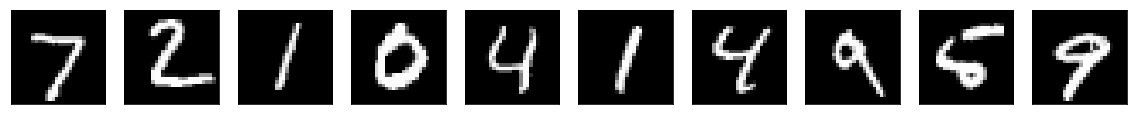

In [4]:
plot_image(X_test)

### Add noise to images

In [5]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

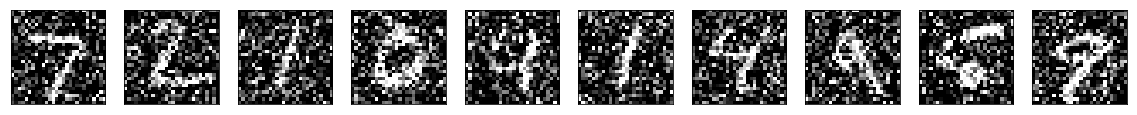

In [6]:
plot_image(X_test_noisy)

### Build the network

In [7]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Train the network

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.1775

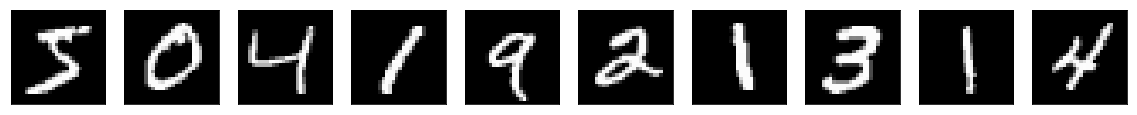

60000/60000 [==============================] - 114s 2ms/step - loss: 0.1775 - val_loss: 0.1289
Epoch 2/10
 9216/60000 [===>..........................] - ETA: 1:30 - loss: 0.1243

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/anaconda2/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/anaconda2/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/anaconda2/lib/python2.7/inspect.py", line 499, in getmodule
    os.pa

IndexError: string index out of range

In [8]:
autoencoder.fit(X_train_noisy, X_train,
                batch_size=128,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test_noisy, X_test),
                callbacks=[Evaluator(X_train)])